## Reading in packages, loading in data

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            classification_report, precision_recall_curve, log_loss
from sklearn import metrics

In [4]:
spotify_df = pd.read_csv('spotifytracks.csv')

In [5]:
spotify_df.drop(['genre', 'Unnamed: 0'], axis=1, inplace=True)

In [32]:
spotify_df.columns

Index(['track_name', 'album', 'artist', 'release_date', 'length', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'target'],
      dtype='object')

## Train-Val-Test split, scaling data

In [7]:
X = np.array(spotify_df.iloc[:, 4:-1])
y = np.array(spotify_df.target)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Train and Val scores

In [11]:
logit = LogisticRegressionCV(Cs=1000, cv=10)
logit.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=1000, cv=10)

In [12]:
y_train_pred = logit.predict(X_train_scaled)
y_val_pred = logit.predict(X_val_scaled)

In [13]:
accuracy = metrics.accuracy_score(y_train, y_train_pred)
precision = metrics.precision_score(y_train, y_train_pred)
recall = metrics.recall_score(y_train, y_train_pred)
f1 = metrics.f1_score(y_train, y_train_pred)

print("Training Set Accuracy:" , round(accuracy, 3))
print("Training Set Precision:", round(precision, 3))
print("Training Set Recall:", round(recall, 3))
print("Training Set F1 Score:", round(f1, 3))

Training Set Accuracy: 0.892
Training Set Precision: 0.893
Training Set Recall: 0.892
Training Set F1 Score: 0.892


In [ ]:
accuracy = metrics.accuracy_score(y_val, y_val_pred)
precision = metrics.precision_score(y_val, y_val_pred)
recall = metrics.recall_score(y_val, y_val_pred)
f1 = metrics.f1_score(y_val, y_val_pred)

print("Val Set Accuracy:" , round(accuracy, 3))
print("Val Set Precision:", round(precision, 3))
print("Val Set Recall:", round(recall, 3))
print("Val Set F1 Score:", round(f1, 3))

## Precision/Recall Curve

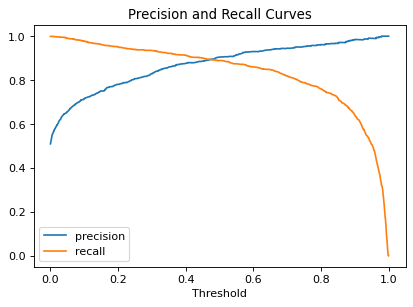

In [44]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, logit.predict_proba(X_val_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

## Confusion Matrix, ROC AUC plot

In [26]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_val_scaled)[:, 1] >= threshold)
    genre_matrix = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=150)
    sns.heatmap(genre_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['jazz', 'rock'],
           yticklabels=['jazz', 'rock']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       804
           1       0.90      0.89      0.90       819

    accuracy                           0.90      1623
   macro avg       0.90      0.90      0.90      1623
weighted avg       0.90      0.90      0.90      1623



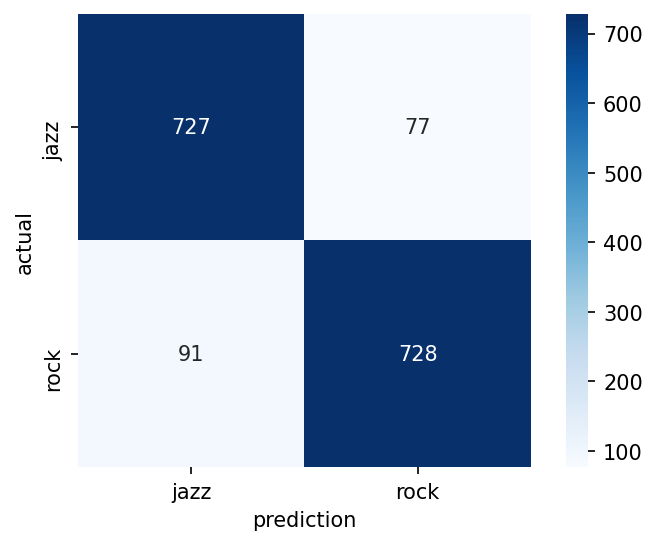

In [27]:
make_confusion_matrix(logit)

In [28]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, logit.predict_proba(X_val_scaled)[:,1])

ROC AUC score =  0.9574532708861068


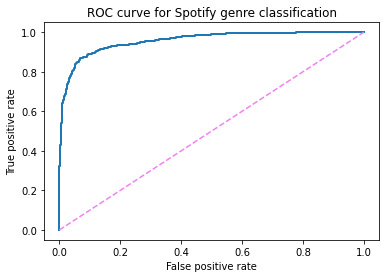

In [31]:
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Spotify genre classification');

print("ROC AUC score = ", roc_auc_score(y_val, logit.predict_proba(X_val_scaled)[:,1]))

## Log Loss

In [43]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_val, logit.predict_proba(X_val_scaled))))

Log-loss on logit: 0.2635
